In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [ ]:
df = pd.read_csv("../dataset/processed.csv")

In [17]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 timestamp                              0
mode                                   0
node_cpu_seconds_total                 0
node_filesystem_avail_bytes            0
node_filesystem_size_bytes             0
node_disk_read_bytes_total             0
node_disk_written_bytes_total          0
node_network_receive_bytes_total       0
node_network_receive_drop_total        0
node_network_receive_errs_total        0
node_network_transmit_packets_total    0
node_vmstat_pgmajfault                 0
node_memory_MemAvailable_bytes         0
node_memory_MemTotal_bytes             0
node_forks_total                       0
node_intr_total                        0
node_load1                             0
node_load5                             0
node_load15                            0
node_sockstat_TCP_alloc                0
node_sockstat_TCP_inuse                0
node_sockstat_TCP_mem                  0
node_sockstat_TCP_mem_bytes            0
node_sockstat_UDP_inuse                0

In [18]:
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


In [19]:
print("\nData Types:\n", df.dtypes)


Data Types:
 timestamp                               object
mode                                    object
node_cpu_seconds_total                 float64
node_filesystem_avail_bytes              int64
node_filesystem_size_bytes               int64
node_disk_read_bytes_total               int64
node_disk_written_bytes_total            int64
node_network_receive_bytes_total         int64
node_network_receive_drop_total          int64
node_network_receive_errs_total          int64
node_network_transmit_packets_total      int64
node_vmstat_pgmajfault                   int64
node_memory_MemAvailable_bytes           int64
node_memory_MemTotal_bytes               int64
node_forks_total                         int64
node_intr_total                          int64
node_load1                             float64
node_load5                             float64
node_load15                            float64
node_sockstat_TCP_alloc                  int64
node_sockstat_TCP_inuse                  int64

In [20]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
        node_cpu_seconds_total  node_filesystem_avail_bytes  \
count            40430.000000                 4.043000e+04   
mean            307482.459519                 3.122294e+11   
std              67402.910775                 2.744203e+10   
min             190158.040000                 2.856264e+11   
25%             249118.212500                 2.856290e+11   
50%             307488.235000                 3.010588e+11   
75%             365851.107500                 3.500017e+11   
max             424971.170000                 3.500040e+11   

       node_filesystem_size_bytes  node_disk_read_bytes_total  \
count                4.043000e+04                4.043000e+04   
mean                 3.404055e+11                1.795149e+09   
std                  2.766115e+10                1.468109e+08   
min                  3.135153e+11                1.614258e+09   
25%                  3.135153e+11                1.614286e+09   
50%                  3.292481

In [21]:
print("\nClass Distribution:\n", df['mode'].value_counts())


Class Distribution:
 mode
normal_traffic    9479
high_traffic      9414
udp_flood         7215
http_flood        6699
icmp_flood        4632
tcp_flood         2991
Name: count, dtype: int64


In [22]:
mode_mapping = {
    "normal_traffic": 0,
    "icmp_flood": 1,
    "udp_flood": 2,
    "high_traffic": 3,
    "tcp_flood": 4,
    "http_flood": 5,
}
df["mode"] = df["mode"].map(mode_mapping)

In [ ]:
if pd.isnull(df).sum().sum() > 0:
    print("Missing values detected! Filling missing values with column mean...")
    df.fillna(df.mean(), inplace=True)

In [ ]:
X = df.drop(columns=["mode"])  # Features
y = df["mode"]  # Target

In [25]:
# Handle timestamp
X["timestamp"] = pd.to_datetime(X["timestamp"])
X["hour"] = X["timestamp"].dt.hour
X["minute"] = X["timestamp"].dt.minute
X["second"] = X["timestamp"].dt.second
X = X.drop(columns=["timestamp"])

In [26]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_accuracies = {name: [] for name in models}

print("Starting model training and evaluation...\n")
for name, model in models.items():
    print(f"Evaluating {name}...")
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[name].append(accuracy)

    print(f"Mean Accuracy for {name}: {np.mean(model_accuracies[name]):.4f}")
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, target_names=mode_mapping.keys()))
    print("\n")

Starting model training and evaluation...

Evaluating Random Forest...
Mean Accuracy for Random Forest: 0.9968
Classification Report for Random Forest:

                precision    recall  f1-score   support

normal_traffic       1.00      1.00      1.00      1903
    icmp_flood       1.00      1.00      1.00       897
     udp_flood       1.00      1.00      1.00      1494
  high_traffic       1.00      1.00      1.00      1883
     tcp_flood       0.99      0.99      0.99       562
    http_flood       0.99      1.00      1.00      1347

      accuracy                           1.00      8086
     macro avg       1.00      1.00      1.00      8086
  weighted avg       1.00      1.00      1.00      8086



Evaluating SVM...
Mean Accuracy for SVM: 0.4702
Classification Report for SVM:

                precision    recall  f1-score   support

normal_traffic       0.48      0.52      0.50      1903
    icmp_flood       0.45      0.22      0.30       897
     udp_flood       0.57      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/l

Mean Accuracy for Logistic Regression: 0.4320
Classification Report for Logistic Regression:

                precision    recall  f1-score   support

normal_traffic       0.44      0.46      0.45      1903
    icmp_flood       0.37      0.22      0.27       897
     udp_flood       0.55      0.62      0.58      1494
  high_traffic       0.42      0.53      0.47      1883
     tcp_flood       0.00      0.00      0.00       562
    http_flood       0.39      0.42      0.40      1347

      accuracy                           0.44      8086
     macro avg       0.36      0.37      0.36      8086
  weighted avg       0.41      0.44      0.42      8086



Evaluating Decision Tree...
Mean Accuracy for Decision Tree: 0.9971
Classification Report for Decision Tree:

                precision    recall  f1-score   support

normal_traffic       1.00      1.00      1.00      1903
    icmp_flood       1.00      1.00      1.00       897
     udp_flood       1.00      1.00      1.00      1494
  high

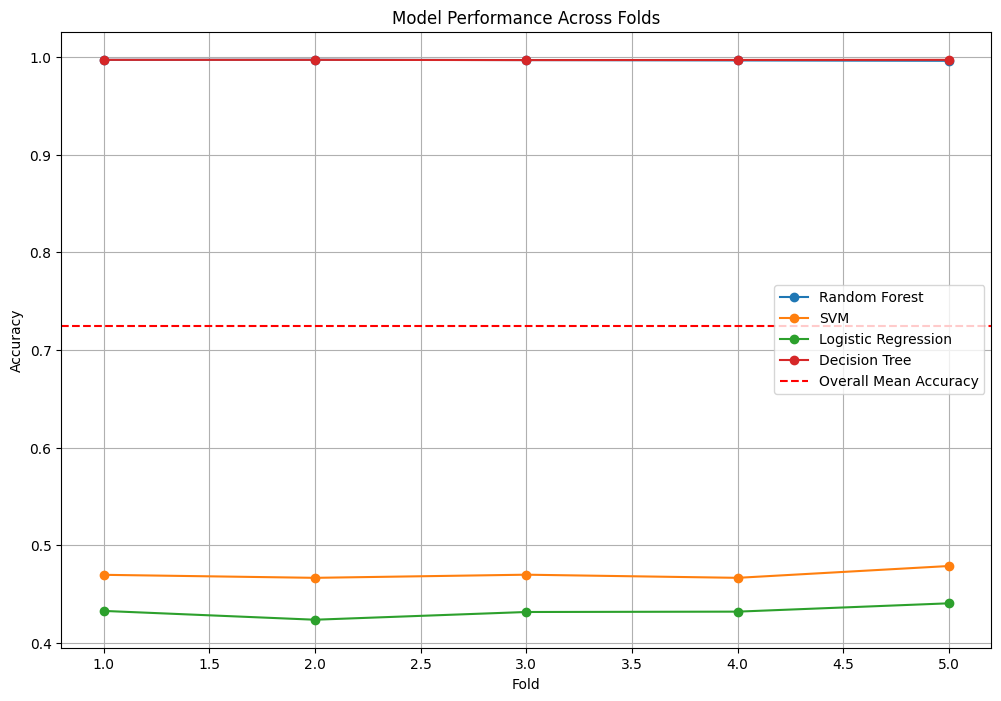

In [32]:
# Plot Accuracies
plt.figure(figsize=(12, 8))
for name, accuracies in model_accuracies.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=name)
plt.axhline(np.mean([np.mean(model_accuracies[name]) for name in models]), color="r", linestyle="--", label="Overall Mean Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Model Performance Across Folds")
plt.legend()
plt.grid()
plt.show()

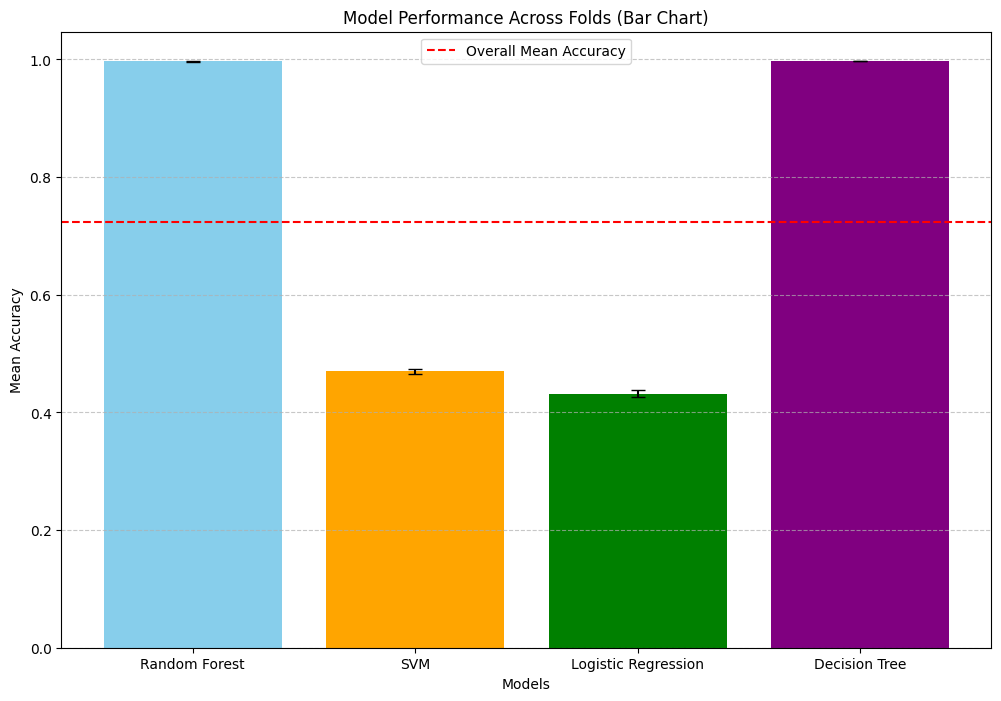

In [ ]:
# Convert accuracies into a bar chart
plt.figure(figsize=(12, 8))

# Prepare data for plotting
means = [np.mean(accuracies) for accuracies in model_accuracies.values()]
stds = [np.std(accuracies) for accuracies in model_accuracies.values()]

# Bar chart
plt.bar(model_accuracies.keys(), means, yerr=stds, capsize=5, color=['skyblue', 'orange', 'green', 'purple'])

# Overall mean accuracy line
overall_mean = np.mean(means)
plt.axhline(overall_mean, color="red", linestyle="--", label="Overall Mean Accuracy")

# Labels and titles
plt.xlabel("Models")
plt.ylabel("Mean Accuracy")
plt.title("Model Performance Across Folds (Bar Chart)")
plt.legend(["Overall Mean Accuracy"])
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()


In [ ]:
best_model = max(models, key=lambda name: np.mean(model_accuracies[name]))
print(f"\nBest Model: {best_model} with Mean Accuracy = {np.mean(model_accuracies[best_model]):.4f}")


Best Model: Decision Tree with Mean Accuracy = 0.9971


Evaluating Random Forest on Test Set...
Random Forest Test Accuracy: 0.9962
Random Forest Test Time: 0.0688 seconds

Classification Report:
                precision    recall  f1-score   support

normal_traffic       1.00      1.00      1.00      1903
    icmp_flood       1.00      1.00      1.00       897
     udp_flood       1.00      1.00      1.00      1494
  high_traffic       1.00      1.00      1.00      1883
     tcp_flood       0.99      0.99      0.99       562
    http_flood       0.99      1.00      1.00      1347

      accuracy                           1.00      8086
     macro avg       1.00      1.00      1.00      8086
  weighted avg       1.00      1.00      1.00      8086



Evaluating SVM on Test Set...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

SVM Test Accuracy: 0.4786
SVM Test Time: 11.9449 seconds

Classification Report:
                precision    recall  f1-score   support

normal_traffic       0.48      0.52      0.50      1903
    icmp_flood       0.45      0.22      0.30       897
     udp_flood       0.57      0.60      0.58      1494
  high_traffic       0.46      0.63      0.53      1883
     tcp_flood       0.00      0.00      0.00       562
    http_flood       0.43      0.44      0.44      1347

      accuracy                           0.48      8086
     macro avg       0.40      0.40      0.39      8086
  weighted avg       0.44      0.48      0.45      8086



Evaluating Logistic Regression on Test Set...
Logistic Regression Test Accuracy: 0.4404
Logistic Regression Test Time: 0.0034 seconds

Classification Report:
                precision    recall  f1-score   support

normal_traffic       0.44      0.46      0.45      1903
    icmp_flood       0.37      0.22      0.27       897
     udp_flood       0.55  

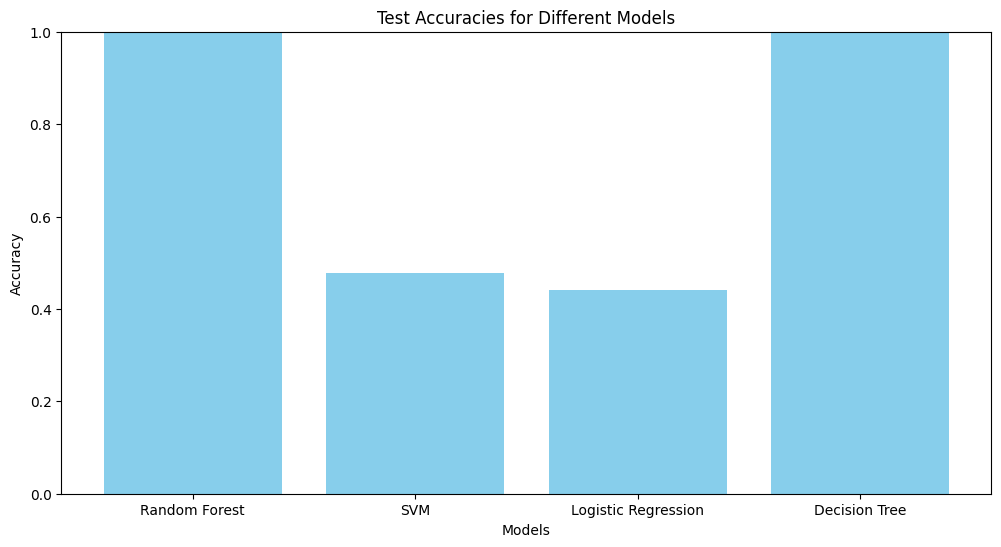

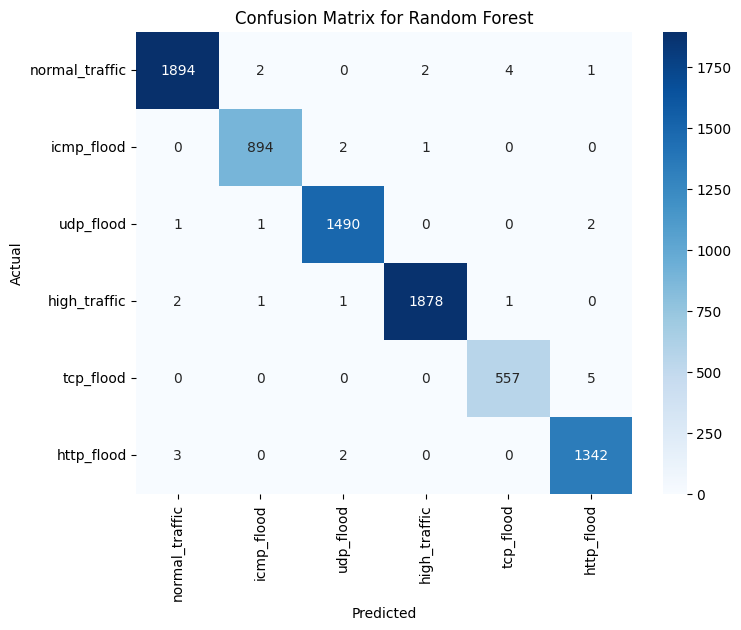

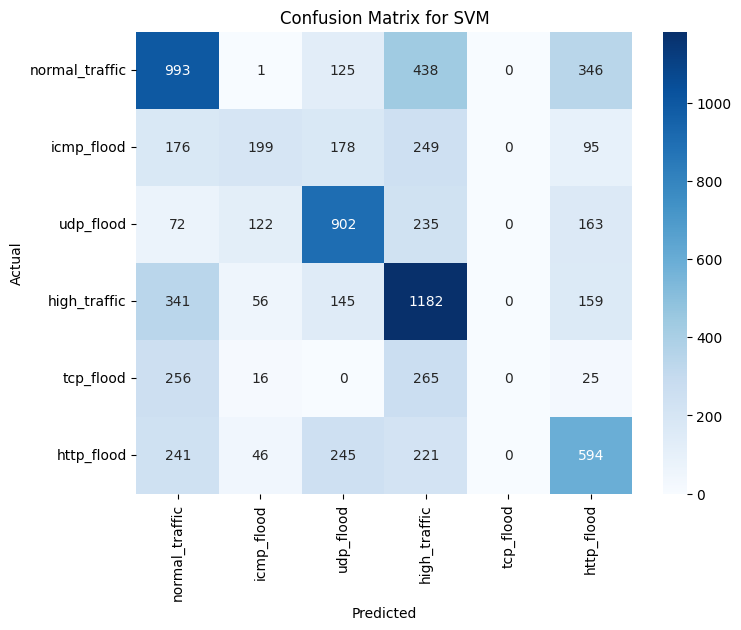

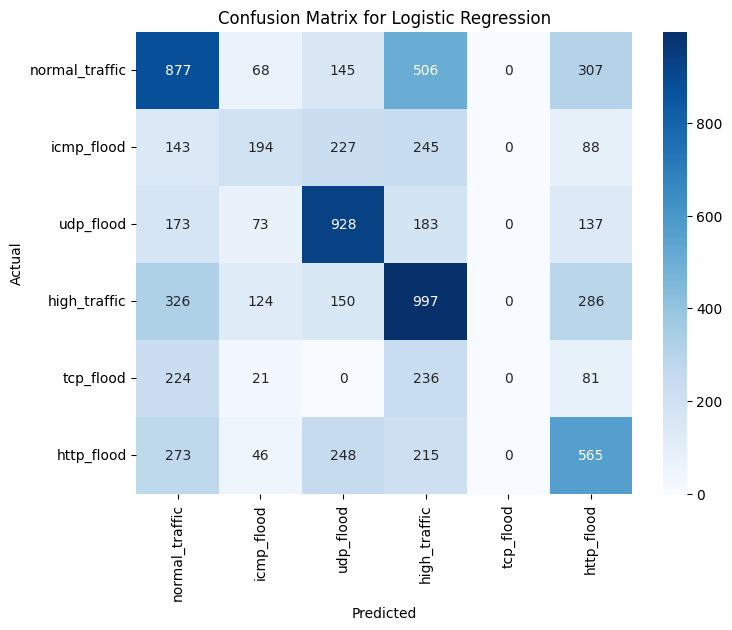

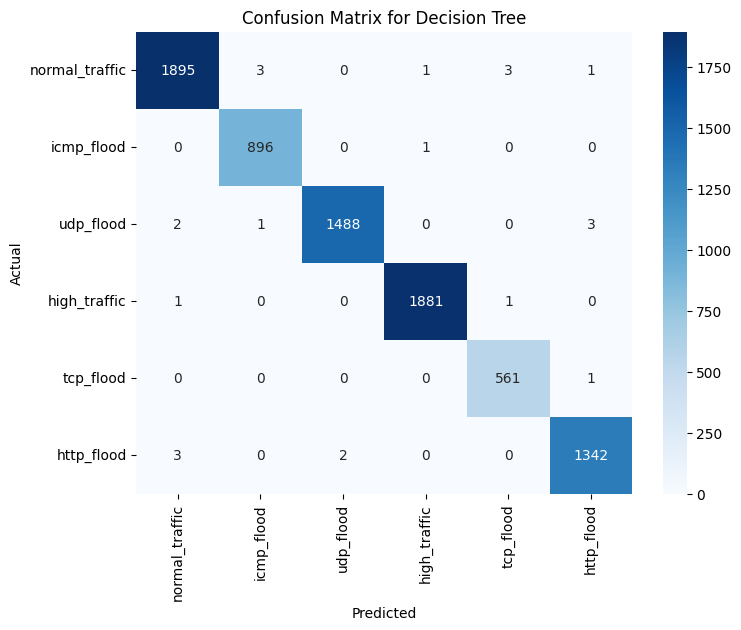

In [ ]:
test_accuracies = {}
classification_reports = {}
confusion_matrices = {}

# Evaluate each model on the test set
for name, model in models.items():
    print(f"Evaluating {name} on Test Set...")
    
    start_time = time.time()
    y_test_pred = model.predict(X_test)
    test_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies[name] = accuracy

    classification_reports[name] = classification_report(
        y_test, y_test_pred, target_names=mode_mapping.keys()
    )

    confusion_matrices[name] = confusion_matrix(y_test, y_test_pred)

    print(f"{name} Test Accuracy: {accuracy:.4f}")
    print(f"{name} Test Time: {test_time:.4f} seconds")
    print("\nClassification Report:")
    print(classification_reports[name])
    print("\n")

# Plot Test Accuracies
plt.figure(figsize=(12, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title("Test Accuracies for Different Models")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.show()

# Plot Confusion Matrices
for name, cm in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mode_mapping.keys(), yticklabels=mode_mapping.keys())
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
